In [1]:
import pandas as pd
import ast
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import textblob
import statistics
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
%load_ext autoreload
%autoreload 2
import Funciones

import warnings
warnings.filterwarnings("ignore")



Se cargan los datos de df_reviews donde se encuentran las reseñas de juegos creadas por los usuarios; y además se cargan tanto el df_games como df_items_añidado, que contienen información relevante para proceder a la realización del análisis de sentimiento con PNL:

In [2]:
ruta_parquet_reviews = r'..\Jupyter\users_reviews.parquet'

In [3]:
ruta_parquet_items = r"..\Data\users_items.parquet"

In [4]:
df_reviews2 = pd.read_parquet(ruta_parquet_reviews)

In [5]:
df_games2 = pd.read_csv('..\Data\steam_games.csv', encoding='utf-8')

In [6]:
df_items2 = pd.read_parquet(ruta_parquet_items)

 Se procede a hacer la exploración y limpieza exhaustiva de cada dataframe, empezando por df_games2:

In [7]:
# Se ve si hay filas duplicadas y se eliminan

Funciones.duplicados_por_columna(df_games2, 'id')



,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
13894,Bethesda Softworks,['Action'],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"['Action', 'FPS', 'Gore', 'Violent', 'Alternat...",http://steamcommunity.com/app/612880/reviews/?...,"['Single-player', 'Steam Achievements', 'Full ...",59.99,0.0,612880.0,Machine Games
14573,Bethesda Softworks,['Action'],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"['Action', 'FPS', 'Gore', 'Violent', 'Alternat...",http://steamcommunity.com/app/612880/reviews/?...,"['Single-player', 'Steam Achievements', 'Full ...",59.99,0.0,612880.0,Machine Games
74,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,NaN,19.99,0.0,NaN,NaN
30961,"Warner Bros. Interactive Entertainment, Feral ...","['Action', 'Adventure']",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"['Action', 'Open World', 'Batman', 'Adventure'...",NaN,"['Single-player', 'Steam Achievements', 'Steam...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


Se puede observar que está el id 612880.0 duplicado; y que además hay 2 id como NaN. Se procede a la eliminación de duplicados.

In [8]:
# se eliminan los index 
index_a_eliminar = [14573, 74, 30961]
df_games2 = df_games2.drop(index_a_eliminar)


In [9]:
# se vuelve a ver si sigue habiendo duplicados
Funciones.duplicados_por_columna(df_games2, 'id')

'No hay duplicados'

Este archivo contiene las siguientes columnas:

•publisher: Empresa publicadora del contenido
•genres: Genero del contenido
•app_name: Nombre del contenido
•title: Titulo del contenido
•url: URL de publicación del contenido
•release_date: Fecha de lanzamiento
•tags: etiquetas de contenido
•reviews_url: Reviews de contenido
•specs: Especificaciones
•price: Precio del contenido
•early_access: acceso temprano
•id: identificador unico de contenido
•developer: Desarrollador


Se transforma la columna 'release_date', ya que se necesita saber el año de lanzamiento de cada juego:

In [10]:
# Se observan las cantidades de registros por cada fecha
df_games2['release_date'].value_counts()

release_date
2012-10-16    100
2017-08-31     92
2017-09-26     89
2017-06-21     82
2017-07-25     78
             ... 
1988-04-16      1
2013-08-24      1
2011-05-07      1
2010-08-21      1
2018-10-01      1
Name: count, Length: 3582, dtype: int64

Se convierten las fechas en datatime, se extraen sólo los años:

In [11]:
df_games2['release_date'] = pd.to_datetime(df_games2['release_date'], errors='coerce')

In [12]:
df_games2['release_date'] = df_games2['release_date'].dt.year

In [13]:
df_games2['release_date'] = df_games2['release_date'].fillna(0.0)
df_games2['release_date'] = df_games2['release_date'].astype(int)

In [14]:
df_games2.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,0.0,761140.0,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980.0,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,0.0,670290.0,Poolians.com
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,0.0,767400.0,彼岸领域
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,0,"['Action', 'Indie', 'Casual', 'Sports']",http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,0.0,773570.0,NaN


In [15]:
Funciones.verificar_tipo_datos(df_games2)

,nombre,tipo_datos,porcentaje_no_nulos,porcentaje_nulos,nulos
0,publisher,"[<class 'str'>, <class 'float'>]",74.88,25.12,8070
1,genres,"[<class 'str'>, <class 'float'>]",89.79,10.21,3282
2,app_name,"[<class 'str'>, <class 'float'>]",100.00,0.00,1
3,title,"[<class 'str'>, <class 'float'>]",93.62,6.38,2049
4,url,[<class 'str'>],100.00,0.00,0
5,release_date,[<class 'int'>],100.00,0.00,0
6,tags,"[<class 'str'>, <class 'float'>]",99.50,0.50,162
7,reviews_url,[<class 'str'>],100.00,0.00,0
8,specs,"[<class 'str'>, <class 'float'>]",97.92,2.08,669
9,price,"[<class 'str'>, <class 'float'>]",95.71,4.29,1377


In [16]:
df_games2.head(5)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,0.0,761140.0,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980.0,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,0.0,670290.0,Poolians.com
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,0.0,767400.0,彼岸领域
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,0,"['Action', 'Indie', 'Casual', 'Sports']",http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,0.0,773570.0,NaN


Se observa la columna 'price':

In [17]:
df_games2['price'].unique()

array(['4.99', 'Free To Play', 'Free to Play', '0.99', '2.99', '3.99',
       '9.99', '18.99', '29.99', nan, 'Free', '10.99',
       '1.5899999999999999', '14.99', '1.99', '59.99', '8.99', '6.99',
       '7.99', '39.99', '19.99', '7.49', '12.99', '5.99', '2.49', '15.99',
       '1.25', '24.99', '17.99', '61.99', '3.49', '11.99', '13.99',
       'Free Demo', 'Play for Free!', '34.99', '74.76', '1.49', '32.99',
       '99.99', '14.95', '69.99', '16.99', '79.99', '49.99', '5.0',
       '44.99', '13.98', '29.96', '119.99', '109.99', '149.99', '771.71',
       'Install Now', '21.99', '89.99', 'Play WARMACHINE: Tactics Demo',
       '0.98', '139.92', '4.29', '64.99', 'Free Mod', '54.99', '74.99',
       'Install Theme', '0.89', 'Third-party', '0.5', 'Play Now',
       '299.99', '1.29', '3.0', '15.0', '5.49', '23.99', '49.0', '20.99',
       '10.93', '1.3900000000000001', 'Free HITMAN™ Holiday Pack',
       '36.99', '4.49', '2.0', '4.0', '9.0', '234.99',
       '1.9500000000000002', '1.5', '1

Se observan de las columnas 'publisher', 'app_name', 'title', 'developer':

In [18]:
df_games2['publisher']


0               Kotoshiro
1        Making Fun, Inc.
2            Poolians.com
3                    彼岸领域
4                     NaN
               ...       
32130     Ghost_RUS Games
32131              Sacada
32132        Laush Studio
32133            SIXNAILS
32134                 NaN
Name: publisher, Length: 32132, dtype: object

In [19]:
df_games2['app_name']

0             Lost Summoner Kitty
1                       Ironbound
2         Real Pool 3D - Poolians
3                         弹炸人2222
4                   Log Challenge
                   ...           
32130              Colony On Mars
32131    LOGistICAL: South Africa
32132               Russian Roads
32133         EXIT 2 - Directions
32134                 Maze Run VR
Name: app_name, Length: 32132, dtype: object

In [20]:
df_games2['title']

0             Lost Summoner Kitty
1                       Ironbound
2         Real Pool 3D - Poolians
3                         弹炸人2222
4                             NaN
                   ...           
32130              Colony On Mars
32131    LOGistICAL: South Africa
32132               Russian Roads
32133         EXIT 2 - Directions
32134                         NaN
Name: title, Length: 32132, dtype: object

In [21]:
df_games2['developer']

0                       Kotoshiro
1                Secret Level SRL
2                    Poolians.com
3                            彼岸领域
4                             NaN
                   ...           
32130          Nikita "Ghost_RUS"
32131                      Sacada
32132    Laush Dmitriy Sergeevich
32133               xropi,stev3ns
32134                         NaN
Name: developer, Length: 32132, dtype: object

En estas columnas se observan valores nulos, entonces se completan con 'Sin Datos'.

In [22]:
# Columnas a transformar
columnas_a_modificar = ['publisher', 'app_name', 'title', 'developer']

valor_a_usar = 'Sin Datos'

# Rellena los valores nulos con el valor especificado
df_games2[columnas_a_modificar] = df_games2[columnas_a_modificar].fillna(valor_a_usar)

Se observa la columna 'genres':

In [23]:
df_games2['genres']

0        ['Action', 'Casual', 'Indie', 'Simulation', 'S...
1             ['Free to Play', 'Indie', 'RPG', 'Strategy']
2        ['Casual', 'Free to Play', 'Indie', 'Simulatio...
3                        ['Action', 'Adventure', 'Casual']
4                                                      NaN
                               ...                        
32130        ['Casual', 'Indie', 'Simulation', 'Strategy']
32131                      ['Casual', 'Indie', 'Strategy']
32132                    ['Indie', 'Racing', 'Simulation']
32133                                  ['Casual', 'Indie']
32134                                                  NaN
Name: genres, Length: 32132, dtype: object

La columna 'genres' tiene para cada item, una lista de distintos géneros del videojuego. Se realiza una columna con cada género.

In [24]:
df_games2 = df_games2.explode('genres')
df_games2 = df_games2.dropna(subset=['genres'])
df_games2.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,0.0,761140.0,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,0.0,643980.0,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,0.0,670290.0,Poolians.com
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,0.0,767400.0,彼岸领域
5,Trickjump Games Ltd,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018,"['Action', 'Adventure', 'Simulation', 'FPS', '...",http://steamcommunity.com/app/772540/reviews/?...,"['Single-player', 'Steam Achievements']",3.99,0.0,772540.0,Trickjump Games Ltd


Se eliminan las colunmas 'specs', 'url', 'reviews_url', y 'price', ya que no nos son de utilidad:


In [25]:
df_games2 = df_games2.drop(['specs', 'url', 'reviews_url', 'price'], axis=1)
df_games2.columns

Index(['publisher', 'genres', 'app_name', 'title', 'release_date', 'tags',
       'early_access', 'id', 'developer'],
      dtype='object')

Se sigue con el df_items2:

Ya se hizo la mayor parte de su tratamiento en el archivo 'ETL_users_items', por lo que se verifica el tipo de dato, y la existencia de nulos:

In [26]:
Funciones.verificar_tipo_datos(df_items2)

,nombre,tipo_datos,porcentaje_no_nulos,porcentaje_nulos,nulos
0,item_id,[<class 'str'>],100.0,0.0,0
1,item_name,[<class 'str'>],100.0,0.0,0
2,playtime_forever,[<class 'int'>],100.0,0.0,0
3,steam_id,[<class 'str'>],100.0,0.0,0
4,items_count,[<class 'int'>],100.0,0.0,0
5,user_id,[<class 'str'>],100.0,0.0,0
6,user_url,[<class 'str'>],100.0,0.0,0


Por último, se revisa el df_reviews2, ya que su mayor tratamiento se realizó en 'ETL_users_review'. Se verifica el tipo de datos y la existencia de nulos:

In [27]:
Funciones.verificar_tipo_datos(df_reviews2)

,nombre,tipo_datos,porcentaje_no_nulos,porcentaje_nulos,nulos
0,user_id,[<class 'str'>],100.0,0.0,0
1,user_url,[<class 'str'>],100.0,0.0,0
2,reviews_posted,[<class 'int'>],100.0,0.0,0
3,reviews_item_id,[<class 'str'>],100.0,0.0,0
4,reviews_helpful,[<class 'str'>],100.0,0.0,0
5,reviews_recommend,[<class 'bool'>],100.0,0.0,0
6,reviews_review,[<class 'str'>],100.0,0.0,0


Se pide que se cree la columna 'sentiment_analysis' aplicando análisis de sentimiento con PNL con la siguiente escala: debes tomar el valor '0' si es malo, '1' si es neutral y '2' si es positivo:  

In [28]:
df_reviews2['sentiment_analysis'] = df_reviews2['reviews_review'].apply(Funciones.analisis_de_sentimiento)

De no ser posible este análisis por estar ausente la reseña escrita, debe tomar el valor de 1:

In [29]:
df_reviews2['sentiment_analysis'].fillna(1, inplace=True)

Se chequean ejemplos:

In [30]:
Funciones.ejemplos_review_por_sentimiento(df_reviews2['reviews_review'], df_reviews2['sentiment_analysis'])

Para la categoría de análisis de sentimiento 0 se tienen estos ejemplos de reviews:
Review 1: This game is Marvellous.
Review 2: BEST GAME IN THE BLOODY WORLD
Review 3: Killed the Emperor, nobody cared and got away with it. Accidentally killed a chicken and everybody decided to gang up on me. 10/10


Para la categoría de análisis de sentimiento 1 se tienen estos ejemplos de reviews:
Review 1: Git gud
Review 2: ZIKA DO BAILE
Review 3: es la rajaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


Para la categoría de análisis de sentimiento 2 se tienen estos ejemplos de reviews:
Review 1: Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.
Review 2: I know what you think when you see this title "Barbie Dreamhouse Party" but do not be intimidated by it's title, this is easi

Esta nueva columna debe reemplazar la de 'user_reviews.review' para facilitar el trabajo de los modelos de aprendizaje automático y el análisis de datos:

In [31]:
df_reviews2['review'] = df_reviews2['sentiment_analysis']

In [32]:
Funciones.verificar_tipo_datos(df_reviews2)

,nombre,tipo_datos,porcentaje_no_nulos,porcentaje_nulos,nulos
0,user_id,[<class 'str'>],100.0,0.0,0
1,user_url,[<class 'str'>],100.0,0.0,0
2,reviews_posted,[<class 'int'>],100.0,0.0,0
3,reviews_item_id,[<class 'str'>],100.0,0.0,0
4,reviews_helpful,[<class 'str'>],100.0,0.0,0
5,reviews_recommend,[<class 'bool'>],100.0,0.0,0
6,reviews_review,[<class 'str'>],100.0,0.0,0
7,sentiment_analysis,[<class 'int'>],100.0,0.0,0
8,review,[<class 'int'>],100.0,0.0,0


In [33]:
df_reviews2.head()

,user_id,user_url,reviews_posted,reviews_item_id,reviews_helpful,reviews_recommend,reviews_review,sentiment_analysis,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,2,2
1,js41637,http://steamcommunity.com/id/js41637,2014,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,2,2
2,evcentric,http://steamcommunity.com/id/evcentric,3,248820,No ratings yet,True,A suitably punishing roguelike platformer. Wi...,2,2
3,doctr,http://steamcommunity.com/id/doctr,2013,250320,2 of 2 people (100%) found this review helpful,True,This game... is so fun. The fight sequences ha...,2,2
4,maplemage,http://steamcommunity.com/id/maplemage,2014,211420,35 of 43 people (81%) found this review helpful,True,Git gud,1,1


Se procede a realizar uniones y transformaciones de los dataframes para facilitar el análisis y trabajo posterior. Se empieza eliminando las columnas 'publisher', 'app_name', 'early_access', 'developer' de df_games2:

In [34]:
columnas_a_eliminar_df_games2 = ['publisher', 'app_name', 'early_access', 'developer']

In [35]:
df_games2=df_games2.drop(columnas_a_eliminar_df_games2, axis=1)

In [36]:
df_games2

,genres,title,release_date,tags,id
0,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,2018,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",761140.0
1,"['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,2018,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",643980.0
2,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,2017,"['Free to Play', 'Simulation', 'Sports', 'Casu...",670290.0
3,"['Action', 'Adventure', 'Casual']",弹炸人2222,2017,"['Action', 'Adventure', 'Casual']",767400.0
5,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,2018,"['Action', 'Adventure', 'Simulation', 'FPS', '...",772540.0
...,...,...,...,...,...
32129,"['Action', 'Adventure', 'Casual', 'Indie']",Kebab it Up!,2018,"['Action', 'Indie', 'Casual', 'Violent', 'Adve...",745400.0
32130,"['Casual', 'Indie', 'Simulation', 'Strategy']",Colony On Mars,2018,"['Strategy', 'Indie', 'Casual', 'Simulation']",773640.0
32131,"['Casual', 'Indie', 'Strategy']",LOGistICAL: South Africa,2018,"['Strategy', 'Indie', 'Casual']",733530.0
32132,"['Indie', 'Racing', 'Simulation']",Russian Roads,2018,"['Indie', 'Simulation', 'Racing']",610660.0


Luego, se eliminan las columnas 'user_id', 'user_url', 'reviews_helpful','reviews_review' de df_reviews2:

In [37]:
columnas_a_eliminar_df_reviews2 = ['user_id', 'user_url', 'reviews_helpful','reviews_review']

In [38]:
df_reviews2=df_reviews2.drop(columnas_a_eliminar_df_reviews2, axis=1)

In [39]:
df_reviews2

,reviews_posted,reviews_item_id,reviews_recommend,sentiment_analysis,review
0,2011,1250,True,2,2
1,2014,251610,True,2,2
2,3,248820,True,2,2
3,2013,250320,True,2,2
4,2014,211420,True,1,1
...,...,...,...,...,...
55733,2015,291480,True,2,2
55737,2014,238460,True,2,2
55738,2015,332310,True,0,0
55739,2014,440,True,2,2


Se eliminan las columnas 'steam_id', y 'user_url' de df_items2:

In [40]:
columnas_a_eliminar_df_items2 = ['steam_id', 'user_url']

In [41]:
df_items2=df_items2.drop(columnas_a_eliminar_df_items2, axis=1)

In [42]:
df_items2

,item_id,item_name,playtime_forever,items_count,user_id
0,10,Counter-Strike,6,277,76561197970982479
1,20,Team Fortress Classic,0,277,76561197970982479
2,30,Day of Defeat,7,277,76561197970982479
3,40,Deathmatch Classic,0,277,76561197970982479
4,50,Half-Life: Opposing Force,0,277,76561197970982479
...,...,...,...,...,...
5153204,346330,BrainBread 2,0,7,76561198329548331
5153205,373330,All Is Dust,0,7,76561198329548331
5153206,388490,One Way To Die: Steam Edition,3,7,76561198329548331
5153207,521570,You Have 10 Seconds 2,4,7,76561198329548331


Se renombran las columnas referidas al id del item, para que los 3 dataframes tengan la columna de igual nombre 'item_id':

In [43]:
df_games2= df_games2.rename(columns={'id': 'item_id'})

In [44]:
df_reviews2 = df_reviews2.rename(columns={'reviews_item_id': 'item_id'})

Se ve de qué tipo son las columnas 'item_id' de cada dataframe, y se convierten a int:

In [45]:
df_games2.dtypes

genres           object
title            object
release_date      int32
tags             object
item_id         float64
dtype: object

In [46]:
df_reviews2.dtypes

reviews_posted         int64
item_id               object
reviews_recommend       bool
sentiment_analysis     int64
review                 int64
dtype: object

In [47]:
df_items2.dtypes

item_id             object
item_name           object
playtime_forever     int64
items_count          int64
user_id             object
dtype: object

In [48]:
df_games2['item_id'] = df_games2['item_id'].astype(int)

In [49]:
df_reviews2['item_id'] = df_reviews2['item_id'].astype(int)

In [50]:
df_items2['item_id'] = df_items2['item_id'].astype(int)

Se unen los dataframes df_games2 y df_reviews2, a través de la columna 'item_id':

In [51]:
df_combinado = pd.merge(df_games2, df_reviews2, on='item_id', how='inner')

In [52]:
df_combinado 

,genres,title,release_date,tags,item_id,reviews_posted,reviews_recommend,sentiment_analysis,review
0,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",282010,12,True,1,1
1,['Action'],Half-Life,1998,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...",70,2015,True,0,0
2,['Action'],Half-Life,1998,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...",70,31,True,1,1
3,['Action'],Half-Life,1998,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...",70,27,True,1,1
4,['Action'],Half-Life,1998,"['FPS', 'Classic', 'Action', 'Sci-fi', 'Single...",70,28,True,0,0
...,...,...,...,...,...,...,...,...,...
31630,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,2015,True,2,2
31631,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,2015,True,2,2
31632,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,2014,False,1,1
31633,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,2013,True,2,2


In [53]:
columnas_a_eliminar_df_combinado = ['tags']
df_combinado=df_combinado.drop(columnas_a_eliminar_df_combinado, axis=1)


In [91]:
df_combinado

,genres,title,release_date,item_id,reviews_posted,reviews_recommend,sentiment_analysis,review
0,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,12,True,1,1
1,['Action'],Half-Life,1998,70,2015,True,0,0
2,['Action'],Half-Life,1998,70,31,True,1,1
3,['Action'],Half-Life,1998,70,27,True,1,1
4,['Action'],Half-Life,1998,70,28,True,0,0
...,...,...,...,...,...,...,...,...
31630,['Action'],Counter-Strike: Condition Zero,2004,80,2015,True,2,2
31631,['Action'],Counter-Strike: Condition Zero,2004,80,2015,True,2,2
31632,['Action'],Counter-Strike: Condition Zero,2004,80,2014,False,1,1
31633,['Action'],Counter-Strike: Condition Zero,2004,80,2013,True,2,2


Se realiza un archivo parquet con el df combinado:

In [54]:
table = pa.Table.from_pandas(df_combinado)
ruta = r'..\Jupyter\df_combinado.parquet'
pq.write_table(table,ruta)

Se guarda el DataFrame en un archivo Parquet comprimido con Gzip:

In [127]:
file_path_gzip = r'..\Jupyter\df_combinado_gzip.parquet'

# Guardar el DataFrame en un archivo Parquet comprimido con Gzip
df_combinado.to_parquet(file_path_gzip, engine='pyarrow', compression='gzip')

Se genera un DF por cada función de API, dejando sólo las columnas pertinentes para cada una. Luego se guardan como archivo parquet y se comprimen:

In [115]:
columnas_a_eliminar_df_UsersRecommend = ['genres', 'release_date', 'review']
df_UsersRecommend=df_combinado.drop(columnas_a_eliminar_df_UsersRecommend, axis=1)

In [116]:
df_UsersRecommend

,title,item_id,reviews_posted,reviews_recommend,sentiment_analysis
0,Carmageddon Max Pack,282010,12,True,1
1,Half-Life,70,2015,True,0
2,Half-Life,70,31,True,1
3,Half-Life,70,27,True,1
4,Half-Life,70,28,True,0
...,...,...,...,...,...
31630,Counter-Strike: Condition Zero,80,2015,True,2
31631,Counter-Strike: Condition Zero,80,2015,True,2
31632,Counter-Strike: Condition Zero,80,2014,False,1
31633,Counter-Strike: Condition Zero,80,2013,True,2


In [117]:
df_UsersRecommend.to_parquet('..\Jupyter\df_UsersRecommend.parquet')

In [118]:
file_path_gzip_UserRecomend = r'..\Jupyter\df_UsersRecommend_gzip.parquet'


df_UsersRecommend.to_parquet(file_path_gzip_UserRecomend, engine='pyarrow', compression='gzip')

In [123]:
columnas_a_eliminar_df_sentiment_analysis = ['title', 'genres', 'reviews_posted', 'reviews_recommend', 'review']
df_sentiment_analysis=df_combinado.drop(columnas_a_eliminar_df_sentiment_analysis, axis=1)

In [124]:
df_sentiment_analysis

,release_date,item_id,sentiment_analysis
0,1997,282010,1
1,1998,70,0
2,1998,70,1
3,1998,70,1
4,1998,70,0
...,...,...,...
31630,2004,80,2
31631,2004,80,2
31632,2004,80,1
31633,2004,80,2


In [125]:
df_sentiment_analysis.to_parquet('..\Jupyter\df_sentiment_analysis.parquet')

In [126]:
file_path_gzip_sentiment = r'..\Jupyter\df_sentiment_analysis_gzip.parquet'


df_sentiment_analysis.to_parquet(file_path_gzip_sentiment, engine='pyarrow', compression='gzip')

Se unen los dataframes df_games2 y df_items2, a través de la columna 'item_id':

In [94]:
df_combinado2 = pd.merge(df_games2, df_items2, on='item_id', how='inner')

In [95]:
df_combinado2

,genres,title,release_date,tags,item_id,item_name,playtime_forever,items_count,user_id
0,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",282010,Carmageddon Max Pack,5,188,UTNerd24
1,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",282010,Carmageddon Max Pack,0,154,I_DID_911_JUST_SAYING
2,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",282010,Carmageddon Max Pack,0,79,76561197962104795
3,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",282010,Carmageddon Max Pack,0,331,r3ap3r78
4,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,"['Racing', 'Action', 'Classic', 'Indie', 'Gore...",282010,Carmageddon Max Pack,13,583,saint556
...,...,...,...,...,...,...,...,...,...
4156443,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,Counter-Strike: Condition Zero,0,15,76561198273508956
4156444,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,Counter-Strike: Condition Zero,0,5,76561198282090798
4156445,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,Counter-Strike: Condition Zero,0,58,943525
4156446,['Action'],Counter-Strike: Condition Zero,2004,"['Action', 'FPS', 'Shooter', 'Multiplayer', 'S...",80,Counter-Strike: Condition Zero,9,49,76561198283312749


In [96]:
df_combinado2 = df_combinado2.dropna()

In [97]:
df_combinado2['item_id'] = df_combinado2['item_id'].astype('int64')
df_combinado2['release_date'] = df_combinado2['release_date'].astype('int64')

In [98]:
columnas_a_eliminar_df_combinado2 = ['tags', 'item_name', 'items_count']
df_combinado2=df_combinado2.drop(columnas_a_eliminar_df_combinado2, axis=1)

In [99]:
df_combinado2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4156387 entries, 0 to 4156447
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   genres            object
 1   title             object
 2   release_date      int64 
 3   item_id           int64 
 4   playtime_forever  int64 
 5   user_id           object
dtypes: int64(3), object(3)
memory usage: 222.0+ MB


In [100]:
df_combinado2

,genres,title,release_date,item_id,playtime_forever,user_id
0,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,5,UTNerd24
1,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,0,I_DID_911_JUST_SAYING
2,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,0,76561197962104795
3,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,0,r3ap3r78
4,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,13,saint556
...,...,...,...,...,...,...
4156443,['Action'],Counter-Strike: Condition Zero,2004,80,0,76561198273508956
4156444,['Action'],Counter-Strike: Condition Zero,2004,80,0,76561198282090798
4156445,['Action'],Counter-Strike: Condition Zero,2004,80,0,943525
4156446,['Action'],Counter-Strike: Condition Zero,2004,80,9,76561198283312749


In [140]:
df_combinado['item_id'].unique

<bound method Series.unique of 0        282010
1            70
2            70
3            70
4            70
          ...  
31630        80
31631        80
31632        80
31633        80
31634        80
Name: item_id, Length: 31635, dtype: int32>

Se genera un DF por cada función de API, dejando sólo las columnas pertinentes para cada una. Luego se guardan como archivo parquet y se comprimen:

In [101]:
columnas_a_eliminar_df_PlayTimeGenre = ['title', 'user_id']
df_PlayTimeGenre=df_combinado2.drop(columnas_a_eliminar_df_PlayTimeGenre, axis=1)

In [102]:
df_PlayTimeGenre

,genres,release_date,item_id,playtime_forever
0,"['Action', 'Indie', 'Racing']",1997,282010,5
1,"['Action', 'Indie', 'Racing']",1997,282010,0
2,"['Action', 'Indie', 'Racing']",1997,282010,0
3,"['Action', 'Indie', 'Racing']",1997,282010,0
4,"['Action', 'Indie', 'Racing']",1997,282010,13
...,...,...,...,...
4156443,['Action'],2004,80,0
4156444,['Action'],2004,80,0
4156445,['Action'],2004,80,0
4156446,['Action'],2004,80,9


In [113]:
df_PlayTimeGenre.to_parquet('..\Jupyter\df_PlayTimeGenre.parquet')

In [114]:
file_path_gzip_PlayTimeGenre = r'..\Jupyter\df_PlayTimeGenre_gzip.parquet'


df_PlayTimeGenre.to_parquet(file_path_gzip_PlayTimeGenre, engine='pyarrow', compression='gzip')

In [130]:
columnas_a_eliminar_df_UserForGenre = ['title']
df_UserForGenre=df_combinado2.drop(columnas_a_eliminar_df_UserForGenre, axis=1)

In [131]:
df_UserForGenre

,genres,release_date,item_id,playtime_forever,user_id
0,"['Action', 'Indie', 'Racing']",1997,282010,5,UTNerd24
1,"['Action', 'Indie', 'Racing']",1997,282010,0,I_DID_911_JUST_SAYING
2,"['Action', 'Indie', 'Racing']",1997,282010,0,76561197962104795
3,"['Action', 'Indie', 'Racing']",1997,282010,0,r3ap3r78
4,"['Action', 'Indie', 'Racing']",1997,282010,13,saint556
...,...,...,...,...,...
4156443,['Action'],2004,80,0,76561198273508956
4156444,['Action'],2004,80,0,76561198282090798
4156445,['Action'],2004,80,0,943525
4156446,['Action'],2004,80,9,76561198283312749


In [132]:
df_UserForGenre.to_parquet('..\Jupyter\df_UserForGenre.parquet')


In [133]:
file_path_gzip_UserForGenre = r'..\Jupyter\df_UserForGenre_gzip.parquet'


df_UserForGenre.to_parquet(file_path_gzip_UserForGenre, engine='pyarrow', compression='gzip')

In [105]:
columnas_a_eliminar_df_RecomendacionJuego = ['release_date', 'playtime_forever', 'user_id']
df_RecomendacionJuego=df_combinado2.drop(columnas_a_eliminar_df_RecomendacionJuego, axis=1)

In [106]:
df_RecomendacionJuego

,genres,title,item_id
0,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,282010
1,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,282010
2,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,282010
3,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,282010
4,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,282010
...,...,...,...
4156443,['Action'],Counter-Strike: Condition Zero,80
4156444,['Action'],Counter-Strike: Condition Zero,80
4156445,['Action'],Counter-Strike: Condition Zero,80
4156446,['Action'],Counter-Strike: Condition Zero,80


In [109]:
df_RecomendacionJuego.to_parquet('..\Jupyter\df_RecomendacionJuego.parquet')

In [110]:
file_path_gzip_recomendacion = r'..\Jupyter\df_RecomendacionJuego_gzip.parquet'


df_RecomendacionJuego.to_parquet(file_path_gzip_recomendacion, engine='pyarrow', compression='gzip')

Se realiza un archivo parquet con el df combinado:

In [128]:
df_combinado2.to_parquet('..\Jupyter\df_combinado2.parquet')

Se guarda el DataFrame en un archivo Parquet comprimido con Gzip:

In [129]:
file_path_gzip2 = r'..\Jupyter\df_combinado2_gzip.parquet'


df_combinado2.to_parquet(file_path_gzip2, engine='pyarrow', compression='gzip')

In [64]:
df_combinado2.head()

,genres,title,release_date,item_id,playtime_forever,user_id
0,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,5,UTNerd24
1,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,0,I_DID_911_JUST_SAYING
2,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,0,76561197962104795
3,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,0,r3ap3r78
4,"['Action', 'Indie', 'Racing']",Carmageddon Max Pack,1997,282010,13,saint556


In [71]:
df_items2.head()

,item_id,item_name,playtime_forever,items_count,user_id
0,10,Counter-Strike,6,277,76561197970982479
1,20,Team Fortress Classic,0,277,76561197970982479
2,30,Day of Defeat,7,277,76561197970982479
3,40,Deathmatch Classic,0,277,76561197970982479
4,50,Half-Life: Opposing Force,0,277,76561197970982479


In [72]:
columnas_items_a_eliminar = ['items_count']

In [73]:
df_items2_modificado = df_items2.drop(columnas_items_a_eliminar, axis=1)

In [74]:
df_items2_modificado

,item_id,item_name,playtime_forever,user_id
0,10,Counter-Strike,6,76561197970982479
1,20,Team Fortress Classic,0,76561197970982479
2,30,Day of Defeat,7,76561197970982479
3,40,Deathmatch Classic,0,76561197970982479
4,50,Half-Life: Opposing Force,0,76561197970982479
...,...,...,...,...
5153204,346330,BrainBread 2,0,76561198329548331
5153205,373330,All Is Dust,0,76561198329548331
5153206,388490,One Way To Die: Steam Edition,3,76561198329548331
5153207,521570,You Have 10 Seconds 2,4,76561198329548331


In [75]:
df_reviews2

,reviews_posted,item_id,reviews_recommend,sentiment_analysis,review
0,2011,1250,True,2,2
1,2014,251610,True,2,2
2,3,248820,True,2,2
3,2013,250320,True,2,2
4,2014,211420,True,1,1
...,...,...,...,...,...
55733,2015,291480,True,2,2
55737,2014,238460,True,2,2
55738,2015,332310,True,0,0
55739,2014,440,True,2,2


Se procede con el EDA:

In [76]:
df_games2.describe()

,release_date,item_id
count,28850.000000,2.885000e+04
mean,1993.691612,4.410407e+05
std,205.428563,1.851197e+05
min,0.000000,1.000000e+01
25%,2014.000000,3.180275e+05
50%,2016.000000,4.354450e+05
75%,2017.000000,5.864875e+05
max,2021.000000,2.028850e+06


In [77]:
df_reviews2.describe()

,reviews_posted,item_id,sentiment_analysis,review
count,37332.000000,37332.000000,37332.000000,37332.000000
mean,1670.413667,166615.273787,1.355406,1.355406
std,754.258918,133106.470770,0.807211,0.807211
min,1.000000,10.000000,0.000000,0.000000
25%,2013.000000,4577.500000,1.000000,1.000000
50%,2014.000000,214950.000000,2.000000,2.000000
75%,2015.000000,260230.000000,2.000000,2.000000
max,2015.000000,527340.000000,2.000000,2.000000


In [78]:
df_items2.describe()

,item_id,playtime_forever,items_count
count,5.094105e+06,5.094105e+06,5.094105e+06
mean,1.783916e+05,9.905511e+02,3.157324e+02
std,1.318516e+05,5.414297e+03,6.969073e+02
min,1.000000e+01,0.000000e+00,1.000000e+00
25%,3.445000e+04,0.000000e+00,7.100000e+01
50%,2.144200e+05,3.400000e+01,1.370000e+02
75%,2.664300e+05,3.550000e+02,2.750000e+02
max,5.307200e+05,6.427730e+05,7.762000e+03


Se verifica el total de juegos con el 'item_id' de 'df_games2':

In [79]:
total_juegos = len(df_games2['item_id'].unique())
print(total_juegos)

28850


Se ve qué categorías de juegos son las que predominan:

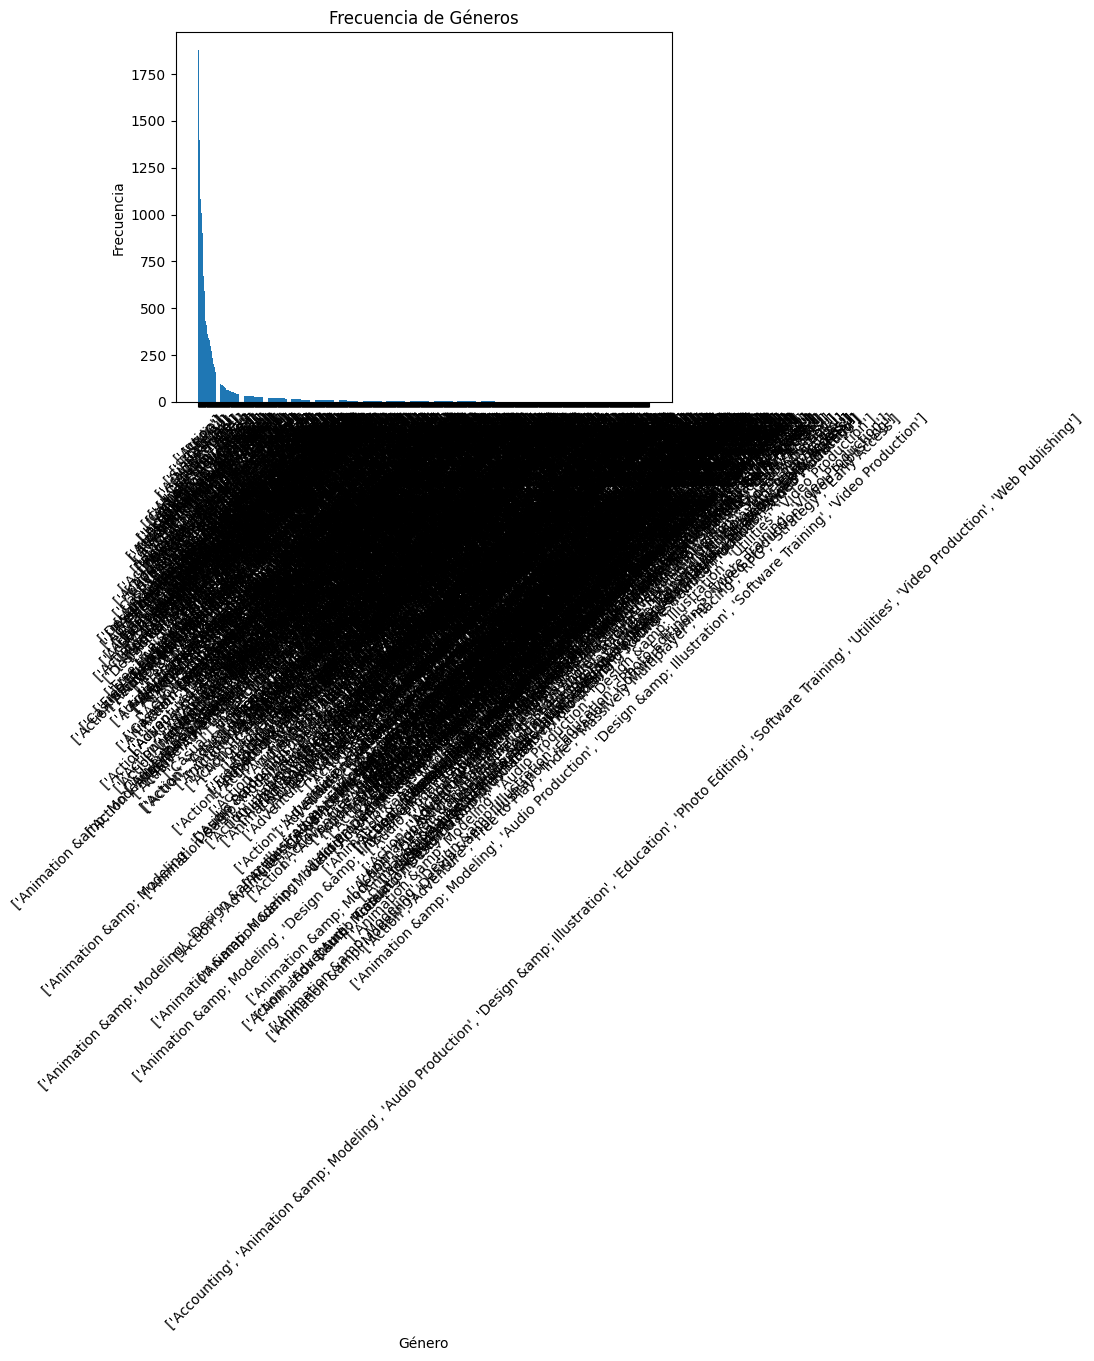

In [80]:
plt.bar(df_games2['genres'].value_counts().index, df_games2['genres'].value_counts())
plt.title('Frecuencia de Géneros')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [81]:
Funciones.cantidad_porcentaje(df_games2, 'genres')

,Cantidad,Porcentaje
genres,,
['Action'],1879,6.51
"['Action', 'Indie']",1650,5.72
['Simulation'],1396,4.84
"['Casual', 'Simulation']",1359,4.71
"['Action', 'Adventure', 'Indie']",1082,3.75
...,...,...
"['Action', 'Adventure', 'Racing', 'Simulation', 'Strategy']",1,0.00
"['Action', 'Adventure', 'Casual', 'Indie', 'Racing', 'Sports', 'Strategy']",1,0.00
"['Action', 'Adventure', 'Casual', 'Indie', 'Racing', 'Simulation', 'Sports']",1,0.00


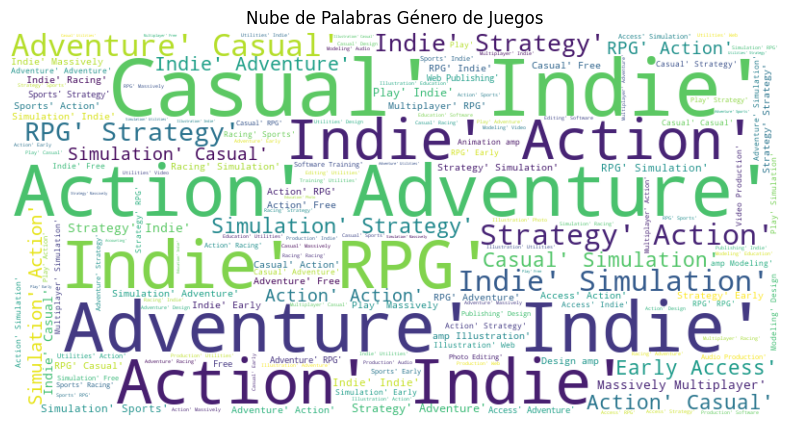

In [82]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_games2['genres']))


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Género de Juegos')
plt.show()

Se analiza la cantidad de juegos de acuerdo al año de lanzamiento:

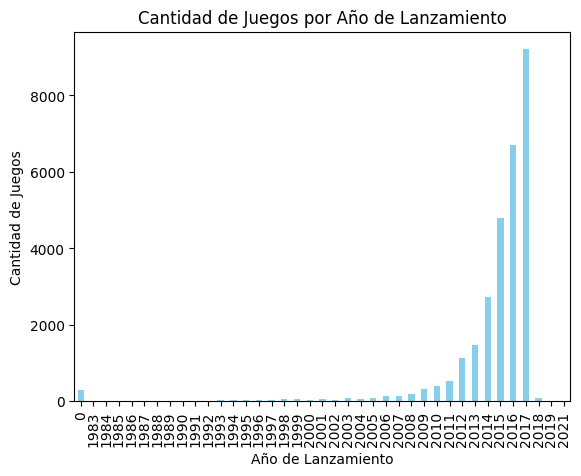

In [83]:
conteo_anios = df_games2['release_date'].value_counts().sort_index()
conteo_anios.plot(kind='bar', color='skyblue')
plt.ylabel('Cantidad de Juegos')
plt.xlabel('Año de Lanzamiento')
plt.title('Cantidad de Juegos por Año de Lanzamiento')
plt.show()

In [84]:
Funciones.cantidad_porcentaje(df_games2, 'release_date')

,Cantidad,Porcentaje
release_date,,
2017,9207,31.91
2016,6691,23.19
2015,4794,16.62
2014,2728,9.46
2013,1477,5.12
2012,1137,3.94
2011,541,1.88
2010,393,1.36
2009,316,1.10


Se analizan las columnas 'sentiment_analysis' y 'reviews_recommend' de 'df_reviews2':

In [85]:
Funciones.cantidad_porcentaje(df_reviews2, 'sentiment_analysis')

,Cantidad,Porcentaje
sentiment_analysis,,
2,21154,56.66
1,8292,22.21
0,7886,21.12


In [86]:
Funciones.cantidad_porcentaje(df_reviews2, 'reviews_recommend')

,Cantidad,Porcentaje
reviews_recommend,,
True,33088,88.63
False,4244,11.37


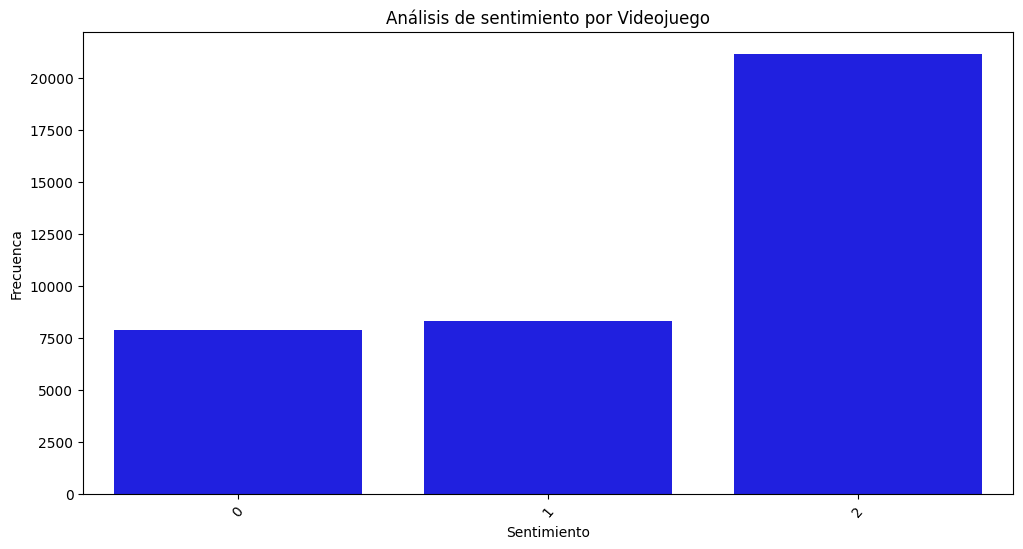

In [87]:
Analisis_sentimiento = df_reviews2['sentiment_analysis'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=Analisis_sentimiento.index, y=Analisis_sentimiento.values, color='blue')
plt.xticks(rotation=50)

plt.xlabel('Sentimiento')
plt.ylabel('Frecuenca')
plt.title('Análisis de sentimiento por Videojuego')

plt.show()

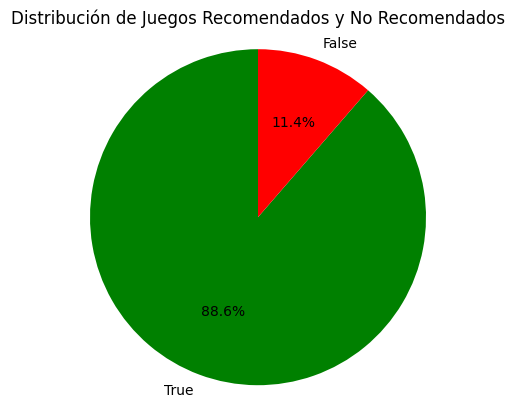

In [88]:
conteo_recomendados = df_reviews2['reviews_recommend'].value_counts()
plt.pie(conteo_recomendados, labels=conteo_recomendados.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.axis('equal')  
plt.title('Distribución de Juegos Recomendados y No Recomendados')

plt.show()

Se analiza la columna 'playtime_forever' de df_items2, que hace referencia al tiempo en minutos que el usuario ha jugado:

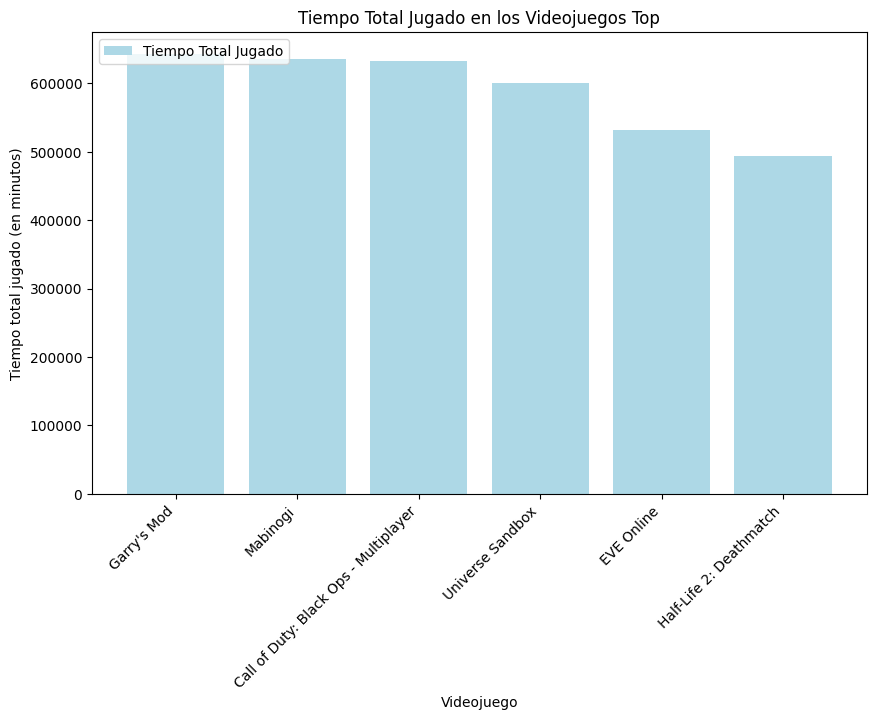

In [89]:
total_top_playtime = df_items2.sort_values(by='playtime_forever', ascending=False).head(10)

plt.figure(figsize=(10, 6))  

plt.bar(total_top_playtime['item_name'], total_top_playtime['playtime_forever'], color='lightblue', label='Tiempo Total Jugado')
plt.xlabel('Videojuego')
plt.ylabel('Tiempo total jugado (en minutos)')
plt.title('Tiempo Total Jugado en los Videojuegos Top')
plt.xticks(rotation=45, ha='right')

plt.legend(loc='upper left')

plt.show()